# LDA con Iris

Utilizando el dataset **IRIS**, vamos a ilustrar la aplicación del modelo LDA como modelo de clasificación y como técnica de reducción de dimensionalidad supervisada. 

En efecto, LDA permite encontrar un nuevo espacio de representación donde los ejes producidos van a ser combinaciones lineales de los ejes originales (al igual que con **PCA**), pero van a estar ordenados con respecto a la mayor **separabilidad** de las clases (al contrario de PCA, donde lo importante es la explicación de varianza de cada eje encontrado).


## Entendimiento de los datos

**EXPLICACIÓN**: Se cargan las librerias a utilizar.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**EXPLICACIÓN**: Se cargar el archivo csv que contiene el set de datos a utilizar y ademas se despliega su forma (numero de filas y de columnas) y se muestran los primeros 5 registros

Leemos el archivo con el dataset, cargándolo en memoria

In [2]:
df = pd.read_csv('05-02-iris.csv', sep=';')
print(df.shape)
df.head(5)

(150, 5)


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


Hagamos un gráfico de barras que cuente los valores de la variable categórica objetivo "variety".

**Explicación**: Se genera una diagrama de barras donde se visualiza la cantidad de registros segmentandolos por variedad, donde se observa que todas las clase poseen el mismo numero de registros asociados y por lo tanto el set de datos esta balanceado.

<AxesSubplot:xlabel='variety', ylabel='count'>

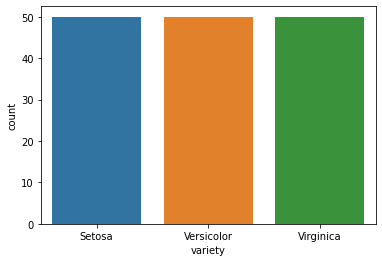

In [3]:
sns.countplot(x="variety", data=df)

Esta variable devuelve un objeto gráfico, que no nos interesa, por lo que lo asignamos a "_" para no obtener mensajes de Python con posiciones de memoria del objeto en cuestión (no es mas que un maquillaje de la salida del notebook).


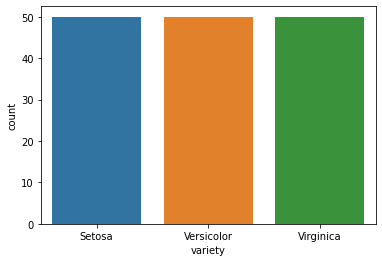

In [4]:
_ = sns.countplot(x="variety", data=df) 

Tenemos 150 instancias, 3 categorías con 50 instancias cada una, y 4 variables numéricas. 

**Explicación**: Se define el numero de variables independientes

In [5]:
# Definimos el número de variables
n=4

Usamos la función *describe* de pandas para obtener un resumen del dataframe (análoga al *summary* de R)

**Explicación**: Se realiza una descripcion estadistica de todas las columnas del set de datos incluyendo las que no son numericas, para esto se utiliza el parametro include="all"

In [6]:
df.describe(include="all")

,sepal.length,sepal.width,petal.length,petal.width,variety
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,Setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


Podemos describir cada una de las columnas, que son en sí arrays independientes:

**Explicación**: Se realiza una descripcion estadistica unicamente de la columna variety

In [7]:
df.variety.describe()

count        150
unique         3
top       Setosa
freq          50
Name: variety, dtype: object

Podemos calcular el accuracy del modelo de clasificación baseline. Como cada clase aparece 50 veces, el accuracy del baseline es de 33.3%.

**Explicación**: Se calcula el accuracy base para obtener un primer punto de comparacion para medir el desempeño de los modelos que se construyan posteriormente teniendo en cuenta que cada clase aparece 5o veces y existen 3 clases en el set de datos, se obtiene un accuracy base del 33.3%

In [8]:
df.variety.describe()['freq'] / df.variety.describe()['count']

0.3333333333333333

## Preprocesamiento de los datos

Vamos a normalizar los datos para que todas las variables originales tengan la misma importancia en modelos basados en distancia (no es el caso con LDA, pero lo mostramos para ilustrar el proceso en Python).

Existen diferentes clases en Scikit-learn que se encargan de los procesos de normalización: **MinMaxScaler** (limita los valores a un intervalo determinado), **MaxAbsScaler** (escala los datos para que el máximo valor absoluto sea 1, sin centrar los datos), **StandardScaler** (estandariza los datos), **RobustScaler** (proceso análogo a la estandarización, pero usando estadísticas robustas a los valores excepcionales - mediana y rango intercuartil).

Utilizamos la clase **StandardScaler**, para reescalar las primeras 4 columnas (las numéricas) que recibe los siguientes parámetros:
* *copy*: por defecto *True*, indica si se debe trabajar sobre los datos originales o sobre una copia que se debe crear. Dependiendo del tipo de los datos de entrada, puede que sea necesaria la copia (e.g. una matriz dispersa).
* *with_mean*: por defecto *True*, indica si se debe centrar los datos o no (para que queden con promedio 0)
* *with_std*: por defecto *True*, indica si se debe escalar los datos para que queden con una unidad de desviación estándar.

Todas las clases de reescalado de los valores son modelos que deben aprender parámetros de un conjunto de datos (método **fit**, aplicado por ejemplo a un training set), para poder aplicar el proceso a ese (método **fit_transform**) u otro conjunto de datos (método **transform** aplicado a un test set).

**Explicación**: Se realiza la estandarización de las variables independientes (Primeras n=4 columnas) utilizando la clase StandardScaler

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(df.iloc[:,range(0,n)].values)

Las clases de reescalado retornan objetos de tipo numpy array (no son dataframes de pandas)

**Explicación**: Se despliega el tipo de dato del resultado obtenido al estandarizar los datos almacenado en X_std

In [10]:
type(X_std)

numpy.ndarray

Por lo tanto, no podemos utilizar el método **head** para visualizar el contenido de sus primeros registros; utilizamos el operador de indexación

**Explicación**: Se despliegan las primeras 5 filas del resultado de la estandarizacion

In [11]:
X_std[0:5,:]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

Comparemos con los datos originales del dataframe

**Explicación**: Se despliegan las primeras 5 filas del set de datos original sin estandarizar

In [12]:
df.head(5)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


Podemos verificar que los datos tienen, en cada variable, un promedio de 0 y una desviación estándar de 1, utilizando los métodos **mean** y **std**. 
Cabe anotar que como lo que tenemos es una matriz de datos, hay que especificar el eje (*axis*) sobre el cual queremos calcular las estadísticas: 0 para las columnas, 1 para las filas. 
Por otra parte, recordemos que al realizar cálculos en un computador, puede que los valores que encontremos no sean exactamente 0 y 1, sino valores aproximados muy pequeños.

**Explicación**: Se verifica que la estandarizacion de las variables se haya realizado correctamente calculando el promedio y la desviacion estandar a lo largo de las filas (axis=0) del resultado obtenido, esperando que estos valores sean muy cercanos a 0 y 1 respectivamente.

In [13]:
np.mean(X_std, axis=0)


array([-4.73695157e-16, -7.81597009e-16, -4.26325641e-16, -4.73695157e-16])

In [14]:
np.std(X_std, axis=0)

array([1., 1., 1., 1.])

## Construcción del modelo LDA "a pie"

Vamos a buscar reducir las dimensiones del dataset Iris, pasando de 4 variables originales a las 2 dimensiones mas discriminantes, tal y como las calcula el modelo LDA.

Los pasos para construir un modelo LDA sobre el dataset de Iris son los siguientes:
* Estandarizar los datos
* Calcular la matriz de dispersión intra clases **$S_{W}$**
* Calcular la matriz de dispersión entre clases **$S_{B}$**
* Calcular los vectores propios y valores propios correspondientes de la matriz **$S_{w}^{-1}S_{b}$**
* Ordenar los vectores propios descendientemente, dados sus valores propios correspondientes.
* Escoger los primeros 2 vectores propios como las columnas de una matriz de transformación **$W$**
* Proyectar las instancias originales sobre el nuevo espacio dimensional utilizando la matriz **$W$**


### 1. Estandarización de los datos

A partir de los datos anteriores ya estandarizados, vamos a crear un nuevo dataframe estandarizado

**Explicación**: Se crea un nuevo dataframe cuyo contenido es el obtenido a partir del proceso de estandarizacion X_std y posteriormente se le asignan los nombres de las columnas originales que se encuentran en el set de datos sin estandarizar.

In [15]:
df_std = pd.DataFrame(X_std)
df_std.columns = df.columns[0:n]
df_std.columns

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width'], dtype='object')

**Explicación**: Se realiza una concatenacion horizontal/columnar (axis=1) del dataframe generado en el paso anterior con la columna de variety y se imprimen los primeros 5 registros.

In [16]:
df_std = pd.concat([df_std, df.variety], axis=1)
df_std.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,-0.900681,1.019004,-1.340227,-1.315444,Setosa
1,-1.143017,-0.131979,-1.340227,-1.315444,Setosa
2,-1.385353,0.328414,-1.397064,-1.315444,Setosa
3,-1.506521,0.098217,-1.283389,-1.315444,Setosa
4,-1.021849,1.249201,-1.340227,-1.315444,Setosa


### 2. Cálculo de la matriz de dispersión intra-clases $S_W$

Vamos a analizar dos tipos de dispersión de los datos (ver imagen siguiente, tomada de https://www.python-course.eu/linear_discriminant_analysis.php):
* la dispersión intra-clase (within): considera la dispersión de las instancias de una misma clase con respecto a su centro propio
* la dispersión inter-clase (between): considera la dispersión de los datos de las clases (resumidos por sus promedios correspondientes) y el promedio global del conjunto de datos.



![title](WithinBetween.png)

Se calcula la matriz de dispersión **$S_{k}$** interna de cada clase k. 
Vamos a considerar las diferencias entre cada instancia de la clase y su promedio:

$S_{k} = \sum_{x\in k}{(x-\mu_{k})(x-\mu_{k})^T}$

Para calcular la matriz de dispersión intra-clases global a todas las clases **$S_{W}$**, se deben de agregar las matrices **$S_{k}$**.
Teniendo en cuenta que alguna de las clases puede estar más o menos representada en el conjunto de datos total, hay que re escalar las matrices con respecto a su cardinalidad **$n_{k}$**. 
Esto equivale entonces a que se pueden utilizar las matrices de covarianza de cada clase como una versión re-escalada de la matriz de dispersión intra-clase **$S_{k}$**:

$Cov_{k} = \frac{1}{n_k-1}\sum_{x\in k}{(x-\mu_{k})(x-\mu_{k})^T}$

Y, se puede calcular **$S_{W}$** como la suma de las matrices de covarianza:

**Explicación**: Se calcula la matriz de dispersion intra-clases total $S_W$, donde para esto primero se construyen las matrices de covarianza $S_k$ que representan la dispersion interna de cada clase k y despues estas matrices se suman.

In [17]:
S_W = np.zeros((n,n))
for clase in np.unique(df_std.variety):
    S_k = np.cov(df_std.loc[df_std.variety==clase, df_std.columns[0:n]].T)
    print("matriz de covarianza de %s:\n" %{clase}, S_k)
    S_W+=S_k
print("\nmatriz de dispersión intra-clases:\n", S_W)

matriz de covarianza de {'Setosa'}:
 [[0.18241804 0.27673866 0.01126355 0.0164769 ]
 [0.27673866 0.76142015 0.01530537 0.02817403]
 [0.01126355 0.01530537 0.0097429  0.00454089]
 [0.0164769  0.02817403 0.00454089 0.01924361]]
matriz de covarianza de {'Versicolor'}:
 [[0.39116717 0.23759815 0.12595945 0.08896617]
 [0.23759815 0.52179471 0.10814155 0.12485374]
 [0.12595945 0.10814155 0.07133456 0.05469228]
 [0.08896617 0.12485374 0.05469228 0.0677593 ]]
matriz de covarianza de {'Virginica'}:
 [[0.59364215 0.26152874 0.20887174 0.07830273]
 [0.26152874 0.55112336 0.09339157 0.14432078]
 [0.20887174 0.09339157 0.09839686 0.0365287 ]
 [0.07830273 0.14432078 0.0365287  0.1307024 ]]

matriz de dispersión intra-clases:
 [[1.16722735 0.77586555 0.34609473 0.1837458 ]
 [0.77586555 1.83433822 0.21683848 0.29734854]
 [0.34609473 0.21683848 0.17947433 0.09576187]
 [0.1837458  0.29734854 0.09576187 0.21770532]]


### 3. Cálculo de la matriz de dispersión entre-clases $S_B$

Se calcula la matriz de dispersión entre clases **$S_{B}$**, considerando la separación entre los promedios de las clases **$\mu_{k}$** y el promedio global **$\mu$** del conjunto de datos. 
De nuevo, cada clase debe aportar a esta dispersión con respecto a su cardinalidad

$S_{B}= \sum_{k=1}^{K}{n_k(\mu_{k}-\mu)(\mu_{k}-\mu)^T}$

Recordemos que como los datos están estandarizados, los datos están centrados y los promedios de cada variable son nulos (0).

**EXPLIACIÓN**: Se calcula el promedio total de cada columna del set de datos sin discriminar o agrupar por clase y este resultado se convierte en una matriz de numpy

In [18]:
promedio_global = np.asmatrix(np.mean(df_std, axis=0))
promedio_global

/home/cramirez98/Documents/JupyterNotebooks/venvs/Labs/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


matrix([[-4.73695157e-16, -7.81597009e-16, -4.26325641e-16,
         -4.73695157e-16]])

In [19]:
type(promedio_global)

numpy.matrix

Se debe entonces calcular los promedios de cada clase del dataset ('Setosa', 'Versicolor', 'Virginica') vamos a obtener un vector con los promedios y otro con las desviaciones estándar de las variables (sepal.length, sepal.width, petal.length, petal.width).

$\mu_{k} = \frac{1}{n_{k}}\sum_{x\in k}x$

En el siguiente ciclo vamos a calcular los promedios y de una vez acumularlos en la matriz de dispersión inter-clase **$S_B$**

**EXPLIACIÓN**: Se calcula la matriz de dispersion entre clases total $S_B$, donde para esto se calcula la matriz de dispersion $S_B$ para cada clase y despues estas se suman. Para lo anterior, se calcula el numero de registros que posee cada una de las clases (n_clase) y tambien el promedio de los datos que pertenecen a dicha clase (promedio_clase) para posteriormente realizar el calculo de la matriz de dispersion inter-clase.

In [20]:
S_B = np.zeros((n,n))
for clase in np.unique(df_std.variety):
    n_clase = df_std[df_std.variety==clase].shape[0]
    promedio_clase = np.asmatrix(np.mean(df_std[df_std.variety==clase], axis=0))
    S_B += n_clase * (((promedio_clase-promedio_global).reshape(n,1)).dot(((promedio_clase-promedio_global).reshape(1,n))))
S_B

array([[ 92.80585961, -55.65287963, 113.80442453, 113.68762457],
       [-55.65287963,  60.11742706, -74.89110136, -69.48896849],
       [113.80442453, -74.89110136, 141.20575786, 139.73748309],
       [113.68762457, -69.48896849, 139.73748309, 139.33243952]])

Hay que aclarar que es necesario establecer que los vectores de promedios que se van a multiplicar son de hecho matrices, de tal manera que el aporte de cada clase se haga en forma matricial.
Los cambios de la organización dimensional (por ejemplo para una transposición) la hacemos con utilizando función **reshape** de numpy.

A manera de ejemplo, veamos cual sería la forma de la resta entre los dos vectores del promedio de la última clase y del promedio global:

**EXPLIACIÓN**: Se realiza una demostracion de cual es la forma del resultado de restar el promedio de las clases y el promedio global, el cual es el un vector fila (1,4) para despues visualizar el resultado de cambiarle la forma a dicho resultado, generando asi un vector columna (4,1)

In [21]:
promedio_clase.shape

(1, 4)

In [22]:
(promedio_clase-promedio_global).shape

(1, 4)

Tiene una fila y cuatro columnas, vamos a cambiarla a 4 filas por una columna:

In [23]:
(promedio_clase-promedio_global).reshape(n,1).shape

(4, 1)


### 4. Calcular los vectores propios y valores propios correspondientes de la matriz  $𝑆_W^{-1}𝑆_B$ 

A continuación vamos a realizar una descomposición de una matriz cuadrada **$A$** en un conjunto de vectores propios y valores propios. Habrán tantos vectores y valores propios como dimensiones en la matriz original **$A$**.
Para cada vector propio **$v$** y valor propio **$\lambda$** encontramos que:

$A\cdot v = \lambda \cdot v$

Además, si **$Q$** es la matriz que compila los vectores propios en el orden descendente de los valores propios, tenemos que:

$A = Q\cdot diag(\lambda) \cdot Q^{-1}$

Esta descomposición permite analizar algunas propiedades de la matriz **$A$**, de la misma manera que la factorización de un número entero nos permite entender mejor su comportamiento; además, permite simplificar cálculos.

Este tipo de descomposición, aplicada a la matriz de covarianza, se realiza en el método **PCA**, para encontrar ejes  ordenados por orden de varianza explicada descendente. 
En el caso de **LDA**, descomponemos la matriz resultante de la multiplicación de la inversa de la matriz de dispersion intra-clases **$S_W$** por la matriz de dispersión inter-clases **$S_B$**, lo que nos permite encontrar ejes ordenados descendentemente por "poder de discrminancia" (separabilidad ) de las clases consideradas para calcular las matrices de dispersión anteriores.

Dada la complejidad del algoritmo iterativo que permite calcular la descomposición matricial, vamos a utilizar el método **eig** del subpaquete *numpy.linalg*, que recibe la matriz a descomponer y retorna una dupla con sus valores y vectores propios.

**EXPLIACIÓN**: Se calcula la matriz cuadrada A dada por la expresion $A=S_W^{-1} \cdot S_B$, donde $S_W^{-1}$ es la inversa de la matriz de dispersion intra-clases y $S_B$ es la matriz de dispersion entre clases. Posteriormente, a dicha matriz resultante se le calculan los vectores y valores propios.

In [24]:
A= np.linalg.inv(S_W).dot(S_B)
eigen_vals, eigen_vecs = np.linalg.eig(A)

In [25]:
eigen_vecs

array([[ 0.15128777,  0.00693578,  0.5975494 , -0.24753422],
       [ 0.14733266,  0.32786115, -0.17964749, -0.112926  ],
       [-0.85598541, -0.57170517, -0.75937523, -0.60272459],
       [-0.47190474,  0.75207191,  0.18442003,  0.75013172]])

In [26]:
eigen_vals

array([ 1.57740453e+03,  1.39841611e+01,  2.30037164e-13, -4.24885218e-14])

### 5. Ordenar los vectores propios descendientemente, dados sus valores propios correspondientes.

El signo de los valores propios no es importante, solo su magnitud.
Vamos a crear duplas con los valores absolutos de los valores propios y los vectores propios asociados.
Primero lo vamos a hacer de la manera usual con un ciclo, para luego introducir una manera más elegante de realizar estas tareas cíclicas en Python llamada *list comprehension*

**EXPLIACIÓN**: Se almacena en una lista (eigen_pairs) de forma descendiente una serie de tuplas donde en el primer indice de dichas tuplas, se almacena el valor propio y en el segundo el vector propio correspondiente.

In [27]:
eigen_pairs = []
for i in range(len(eigen_vals)):
    eigen_pairs.append( (np.abs(eigen_vals[i]), eigen_vecs[:,i]) )
eigen_pairs

[(1577.4045307156216,
  array([ 0.15128777,  0.14733266, -0.85598541, -0.47190474])),
 (13.98416108853062,
  array([ 0.00693578,  0.32786115, -0.57170517,  0.75207191])),
 (2.3003716423200586e-13,
  array([ 0.5975494 , -0.17964749, -0.75937523,  0.18442003])),
 (4.2488521756720925e-14,
  array([-0.24753422, -0.112926  , -0.60272459,  0.75013172]))]

Este tipo de operaciones son muy comunes, por lo que Python creo las lists comprehensions. A continuación mostramos el código correspondiente

**EXPLIACIÓN**: Se realiza el mismo proceso anterior pero esta vez de forma mas simplificada utilizando list comprehensions.

In [28]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs

[(1577.4045307156216,
  array([ 0.15128777,  0.14733266, -0.85598541, -0.47190474])),
 (13.98416108853062,
  array([ 0.00693578,  0.32786115, -0.57170517,  0.75207191])),
 (2.3003716423200586e-13,
  array([ 0.5975494 , -0.17964749, -0.75937523,  0.18442003])),
 (4.2488521756720925e-14,
  array([-0.24753422, -0.112926  , -0.60272459,  0.75013172]))]

Veamos finalmente los valores propios ordenados en orden descendente.

**EXPLIACIÓN**: Se imprimen los valores propios de forma descendente

In [29]:
print('Valores propios en orden descendente:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Valores propios en orden descendente:

1577.4045307156216
13.98416108853062
2.3003716423200586e-13
4.2488521756720925e-14


Vemos que los dos últimos valores propios son casi nulos, y que el primer valor propio es muchísimo mayor al segundo. Esto nos indica que el primer vector propio es bastante discriminante, y que el segundo solo un poco, con los dos últimos ejes nada importantes en la separabilidad de las clases originales.

De hecho, los dos últimos valores propios son en realidad 0, sino que por imprecisiones de cálculo de punto flotante no se logra llegar al valor nulo. La teoría de **LDA** indica que el **máximo número de ejes discriminantes es igual al número de clases -1**. En este caso, como tenemos 3 clases de flores, podemos a lo sumo tener 2 ejes discriminantes. En casos de multicolinearidad, este número de ejes puede ser aún menor.

Podemos confirmar que las ecuaciones presentadas anteriormente se cumplen:

**EXPLIACIÓN**: Se verifica que la condicion $A\cdot v = \lambda \cdot v$ se cumpla, siendo A la matriz calculada anteriormente, $v$ la matriz de vectores propios y $\lambda$ los valores propios.

In [30]:
B = A.dot(eigen_vecs[:, 0])
print(B)
C = eigen_vecs[:, 0] * eigen_vals[0]
print(C)

[  238.64201064   232.40319944 -1350.23526254  -744.38466734]
[  238.64201064   232.40319944 -1350.23526254  -744.38466734]


Finalmente, vamos a visualizar el poder de "separabilidad" de los ejes encontrados visualmente, calculados con respecto a la "separabilidad" total.

**EXPLICACIÓN**: Se calcula del poder de separabilidad de cada uno de los discriminantes calculados, para esto se ordena la lista que contiene los valores y vectores propios de forma descendente y cada valor propio se divide por la suma total de valores propios, obteniendose asi un vector con valores entre 0 y 1, donde entre mas alto es el valor obtenido, mas discriminante es dicho eje.

In [31]:
total_valores = sum(eigen_vals)
separabilidad = [(i / total_valores) for i in sorted(eigen_vals, reverse=True)]
separabilidad

[0.9912126049653671,
 0.008787395034632816,
 1.4455121204312032e-16,
 -2.6699022040022052e-17]

**EXPLICACIÓN**: Se calcula la suma acumulada del vector de poder de separabilidad de cada discriminante calculado y este se grafica en un diagrama de barras donde se observa que el primer discriminante posee el mayor poder de separabilidad con un 99.12% y que los discriminantes 2 y 3 no aportan nada en la separacion de las categorias.

In [32]:
acum_separabilidad = np.cumsum(separabilidad)
acum_separabilidad

array([0.9912126, 1.       , 1.       , 1.       ])

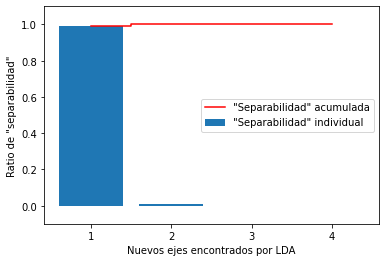

In [33]:
plt.bar(range(1, 5), separabilidad, width=0.8, align='center',label='"Separabilidad" individual')
plt.step(range(1, 5), acum_separabilidad, where='mid', label='"Separabilidad" acumulada', color="red")
plt.ylabel('Ratio de "separabilidad"')
plt.xlabel('Nuevos ejes encontrados por LDA')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.xticks(np.arange(1, 5, step=1))
plt.show()

Podemos confirmar el enorme poder de separabilidad del primer eje (99.2% de la "separabilidad"), el poco poder del segundo, y la ausencia de poder discriminatorio del tercer y cuarto eje.

### 6. Escoger los primeros vectores propios como las columnas de una matriz de transformación  𝑊 

Dado que solo los 2 primeros ejes son importantes en la separabilidad de las clases, vamos a representar el conjunto de datos en estas 2 primeras dimensiones. Necesitamos una manera de transformar los datos del sistema de coordenadas original al sistema reducido, para eso creamos una matriz de transformación **$W$**a partir de los 2 vectores propios más importantes.

**EXPLICACIÓN**: Se contruye la matriz de transformacion $W$ para de esta manera poder representar el set de datos en las dos primeras dimensiones, definidas por los dos primeros vectores propios organizados de forma descendiente con respecto a sus valores propios.

In [34]:
# El primer eje indica el orden descendente de los pares, 
# el segundo identifica que se quiere el segundo elemento de la tupla (ya que el primero es el valor propio).
# Luego indicamos que queremos todas las filas del vector, pero que lo queremos transformar para que quede 
# con m (=4) filas y 1 sola columna cada uno, para poder apilarlos horizontalmente
# formando una matriz de 4 filas y dos columnas
W = np.hstack((
    eigen_pairs[0][1][:, ].reshape(n,1), 
    eigen_pairs[1][1][:, ].reshape(n,1)
))
W

array([[ 0.15128777,  0.00693578],
       [ 0.14733266,  0.32786115],
       [-0.85598541, -0.57170517],
       [-0.47190474,  0.75207191]])

### 7. Proyectar las instancias originales sobre el nuevo espacio dimensional utilizando la matriz  𝑊

Vamos a transformar el dataset original al nuevo sistema de representación, utilizando la matriz **$W$**:

$X^{'}=X\cdot W$

**EXPLICACIÓN**: Se realiza una transformacion lineal sobre el dataset original estandarizado almacenado en el dataframe df_std utilizando la matriz de transformacion $W$ calculada anteriormente para asi obtener una representacion del dataset original en las dimensiones definidas por los discriminantes calculados anteriormente.

In [35]:
df_std_lda = pd.DataFrame(df_std.loc[:,df_std.columns[0:n]].dot(W))
df_std_lda["clase"] = df_std.loc[:,["variety"]]
print("Tamaño del nuevo conjunto de datos: ", df_std_lda.shape)
df_std_lda.columns=["LD1", "LD2", "clase"]
df_std_lda.head()

Tamaño del nuevo conjunto de datos:  (150, 3)


,LD1,LD2,clase
0,1.781849,0.104751,Setosa
1,1.575609,-0.274293,Setosa
2,1.655430,-0.092534,Setosa
3,1.505879,-0.233836,Setosa
4,1.797434,0.179383,Setosa


Visualicemos las instancias en el nuevo sistema de coordenadas:

**EXPLICACIÓN**: Se realiza el grafico de dispersion y el grafico de pares del dataset en el sistema de coordenadas definido por los discriminantes calculados, donde se observa que mediante el algoritmo LDA se logro reducir la dimensionalidad del set de datos de $\R^4$ a $\R^2$, lograndose tambien que las tres categorias tengan la mejor separacion posible.

In [36]:
markers = ['s', 'x','o']

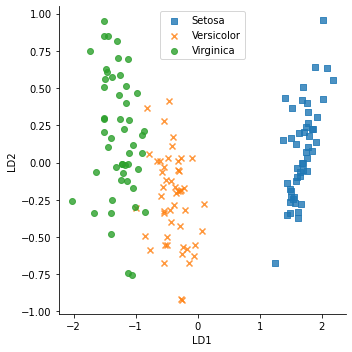

In [37]:
sns.lmplot(x="LD1", y="LD2", data=df_std_lda, markers=markers, fit_reg=False, hue='clase', legend=False)
plt.legend(loc='upper center')
plt.show()

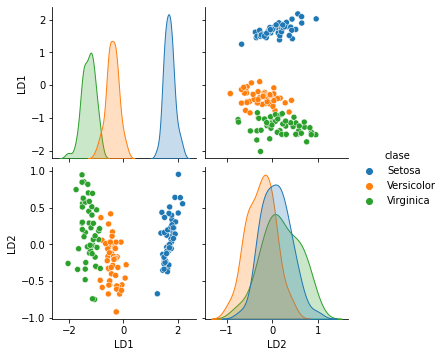

In [38]:
_ = sns.pairplot(df_std_lda, hue="clase")

## Construcción del modelo LDA usando Scikit-learn

Vamos a utilzar directamente las clases de **LDA** existentes en el paquete *sklearn*

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Entre los método de esta clase, destacamos los siguientes:
* **fit**(X,y): entrena el modelo; recibe una matriz con las variables predictivas numéricas *X* y el array con las clases correspondientes *y*, calculando las estructuras internas necesarias tanto para clasificar como la matriz de transformación utilizada para cambiar el sistema de representación de los datos.
* **transform**(X): a llamar una vez el modelo ha sido entrenado para transformar la matriz *X* al nuevo sistema de representación.
* **fit_transform**(X, y): entrena el modelo sobre los datos que recibe (X, y) y retorna la matriz *X* transformada al nuevo sistema de representación.
* **predict**(X): analia los datos *X*, representandos en el sistema de coordenadas originales, y retorna la clase k correspondiente.

Primero vamos a repetir el proceso anterior, en el que solo cambiamos la representación de los datos.

**EXPLICACIÓN**: Se define la variable lda que almacena la clase LinearDiscriminantAnalysis, la cual contiene el modelo LDA y se le brinda como hiperparametro el numero de componentes a obtener, que en este caso es igual a 2, para asi extraer las dos componentes/discriminantes que mejor separen las categorias.

Despues de lo anterior, se genera una dataframe denominado df_std_lda, donde se almacena el resultado de entrenar el modelo LDA con el dataset estandarizado (df_std).

Finalmente se renombran las columnas del resultado del entrenamiento, el cual es precisamente el resultado de representar el dataset ingresado en los 2 componentes o ejes calculados mediante el algoritmo de LDA, donde estas columnas son los dos discriminantes/ejes calculados LD1 y LD2; ademas se le concatena al dataframe con el resultado del entrenamiento la columna con las etiquetas que se encuentra en el dataset estandarizado.

In [40]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [41]:
df_std_lda = pd.DataFrame(lda.fit_transform(df_std.loc[:,df_std.columns[0:n]], df_std.loc[:,df_std.columns[n]]))
df_std_lda.columns=["LD1", "LD2"]
df_std_lda["clase"] = df_std.loc[:,["variety"]]

**EXPLICACIÓN**: Se realiza una serie de graficas de dispersion, donde en la primera se visualizan los datos normalizados sin ser transformados al nuevo eje coordenado y en las subsiguientes graficas se pueden visualizar los datos transformados al nuevo sistema de representacion definido por los discriminantes/ejes calculados, donde se puede analizar como el signo de los ejes no posee interpretacion.

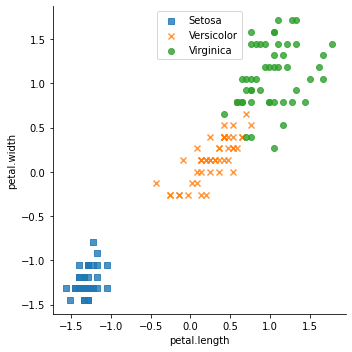

In [42]:
sns.lmplot(x="petal.length", y="petal.width", data=df_std, markers=markers, fit_reg=False, hue='variety', legend=False)
plt.legend(loc='upper center')
plt.show()

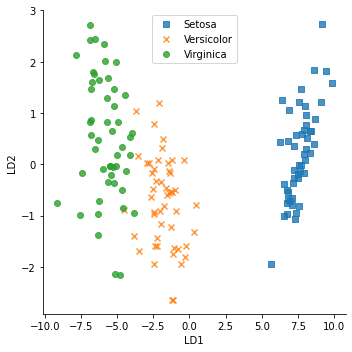

In [43]:
sns.lmplot(x="LD1", y="LD2", data=df_std_lda, markers=markers, fit_reg=False, hue='clase', legend=False)
plt.legend(loc='upper center')
plt.show()

Al igual que con PCA, el signo de los ejes no tiene interpretación, por lo que podemos encontrar de manera aleatoria datos simétricos con respecto a alguno de los ejes nuevos. Esto no cambia en absoluto el resultado.

Como ya lo hablamos previamente, LDA es insensible a cuestiones de escala.

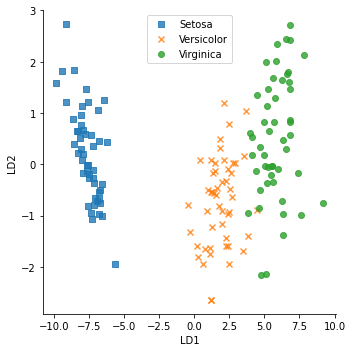

In [44]:
df_std_lda["LD1"] = -df_std_lda["LD1"]
sns.lmplot(x="LD1", y="LD2", data=df_std_lda, markers=markers, fit_reg=False, hue='clase', legend=False)
plt.legend(loc='upper center')
plt.show()

**EXPLICACIÓN**: Por ultimo se ingresan datos de prueba al modelo LDA entrenado y se obtiene la prediccion acerca de a cual categoria pertenece cada uno de dichos datos mediante el metodo predict().

Si queremos utilizar el modelo entrenado para clasificar, lo único que hay que hacer es llamar a su método **predict**:

In [45]:
df_test = [[4.6, 2.9, 5.6, 1.8], [5.1, 3.5, 1.1, 0.2], [3.1, 4.5, 0.1, 0.2]]
y_test_estimada = lda.predict(df_test)
y_test_estimada


/home/cramirez98/Documents/JupyterNotebooks/venvs/Labs/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


array(['Virginica', 'Versicolor', 'Setosa'], dtype='<U10')

## Pipelines en scikit-learn

De la misma manera que en el **lenguaje R** el paquete **caret** permite encadenar el proceso de pretratamiento, entrenamiento de modelos y evaluación, en **scikit-learn** hay una clase llamada **Pipeline** que facilita el encadenamiento secuencial de tareas de transformación y estimación. Además, se puede utilizar para buscar los mejores parámetros para afinar el desempeño del modelo.

Para poder hacer parte de un Pipeline, una tarea intermediaria del "tubo" debe implementar los métodos **fit** y **transform**; la tarea final debe implementar el método **fit**.

A manera de ilustración, vamos a crear un proceso que primero escale los datos, luego cambie la representación de los datos usando **LDA**, y luego aplique un modelo de **KNN** para clasificar las instancias, utilizando un protocolo de evaluación **K-Fold CV**

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Vamos a dividir el conjunto de datos en training set y test set con el método **train_test_split**

**EXPLICACIÓN**: Se realiza la division de los datos en lo respectivos conjuntos de entrenamiento y prueba, donde en este caso se tiene que el 30% de los datos iran al conjunto de prueba.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,range(0,n)],  # matriz con las variables predictivas
    df.iloc[:,n], # array con los valores de la variable objetivo
    test_size=0.3,  # proporción a dejar en el test set
    random_state=30, # para controlar la semilla aleatoria
    stratify=df.iloc[:,n]) # indica la variable de estratificación estratificación de la muestra

Tenemos primero que especificar los pasos a ejecutar secuencialmente, dándoles un nombre e indicando la clase responsable:

**EXPLICACIÓN**: Se definen los pasos que se efectuaran en el pipeline definido, donde primero se efectuara una estandarizacion del set de datos, despues se le aplicara el modelo LDA y por ultimo se entrenara un clasificador K-NN

In [48]:
steps = [('STD', StandardScaler()), ('LDA', LinearDiscriminantAnalysis()), ("KNN", KNeighborsClassifier())]
pipeline = Pipeline(steps)

**EXPLICACIÓN**: Se despliegan las llaves del diccionario que contiene tanto los parametros como los hiperparametros de cada uno de los pasos definidos en el pipeline.

La estimación de los parámetrors no se limita al modelo final. Cualquier parámetro de los pasos intermedios es eligible a ser afinado. Veamos todos los parámetros que podríamos estimar:

In [49]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'STD', 'LDA', 'KNN', 'STD__copy', 'STD__with_mean', 'STD__with_std', 'LDA__covariance_estimator', 'LDA__n_components', 'LDA__priors', 'LDA__shrinkage', 'LDA__solver', 'LDA__store_covariance', 'LDA__tol', 'KNN__algorithm', 'KNN__leaf_size', 'KNN__metric', 'KNN__metric_params', 'KNN__n_jobs', 'KNN__n_neighbors', 'KNN__p', 'KNN__weights'])

Vamos a controlar el parámetro **n_neighbors** del modelo KNN buscando evitar el overfiting.
Para identificar los parámetros a afinar, usamos una concatenación del nombre del paso (en este caso "KNN") y el nombre del parámetro, usando 2 underscores intermedios, es decir: "KNN__n_neighbors".

Vamos a estimar sus valores ideales a partir de una búsqueda en grilla con las combinaciones de valores a testear que especificamos a continuación, utilizando la clase **GridSearchCV** (en este caso al solo haber una variable, no hay combinaciones), que implementa esta búsqueda siguiendo un protocolo de evaluación de K-Fold CV:

**EXPLICACIÓN**: Se define la grid de busqueda mediante validacion cruzada de tipo 5-Fold a partir del pipeline definido, donde esta se encargara de encontrar el numero de vecinos mas cercanos (entre 1 y 9) que permita obtener las mejores metricas de desempeño.

In [50]:
parametros = {'KNN__n_neighbors':[1, 2, 3, 4, 5, 7, 9]}
grid = GridSearchCV(pipeline, param_grid=parametros, cv=5)

Ahora, lo único que tenemos que hacer es buscar el ajuste del Pipeline, llamando el método **fit** de la clase **GridSearchCV**:

**EXPLICACIÓN**: Se realiza el entrenamiento de la grid de busqueda utilizando los datos de entrenamientos definidos anteriormente.

In [51]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('STD', StandardScaler()),
                                       ('LDA', LinearDiscriminantAnalysis()),
                                       ('KNN', KNeighborsClassifier())]),
             param_grid={'KNN__n_neighbors': [1, 2, 3, 4, 5, 7, 9]})

**EXPLICACIÓN**: Se realiza la validacion de la grid de busqueda entrenada anteriormente utilizando el conjunto de datos de prueba, donde esta grid contiene los 3 pasos definidos en el pipeline. A partir de lo anterior se obtiene que el accuracy es del 88% y que el numero de vecinos mas cercanos que brinda las mejores metricas de desempeño es K = 3

In [52]:
print("score = %3.4f" %(grid.score(X_test,y_test)))
print(grid.best_params_)

score = 0.8889
{'KNN__n_neighbors': 3}


A manera de comparación, vamos a crear un nuevo pipeline, utilizando esta vez un **SVM** como paso final. Los parámetros del modelo son C (que controla la penalidad de los elementos que no respetan el margen, ya lo veremos en la siguiente clase)  y gamma (que, en el caso por defecto de un kernel "rbf", con controla la amplitud de las distribuciones gaussianas)

**EXPLICACIÓN**: Se define un nuevo pipeline en donde se cambia el modelo KNN por una maquina de soporte vectorial SVM y donde la grid de busqueda encontrara que valor de gamma entre [0.1,0.01] y que valor del parametro de regularizacion C entre [0.001,0.1,10,100,10e5] maximizan las metricas de desempeño. 

Se obtiene como resultado que el accuracy del modelo es del 97.78% y que el valor de gamma y del parametro de regularizacion C que maximizan esta metrica es 0.1 y 0.001 respectivamente.

In [53]:
steps = [('STD', StandardScaler()), ('LDA', LinearDiscriminantAnalysis()), ("SVM", SVC())]
pipeline = Pipeline(steps)
parametros = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parametros, cv=5)
grid.fit(X_train, y_train)
print("score = %3.4f" %(grid.score(X_test,y_test)))
print(grid.best_params_)

score = 0.9778
{'SVM__C': 0.001, 'SVM__gamma': 0.1}


Veamos la diferencia de resultados con diferentes etapas de preprocesamiento con el clasificador SVM:

**EXPLICACIÓN**: Se define un nuevo pipeline done solo se tiene una maquina de soporte vectorial SVM y donde la grid de busqueda encontrara que valor de gamma entre [0.1,0.01] y que valor del parametro de regularizacion C entre [0.001,0.1,10,100,10e5] maximizan las metricas de desempeño. 

Se obtiene como resultado que el accuracy del modelo es del 93.33% y que el valor de gamma y del parametro de regularizacion C que maximizan esta metrica es 0.01 y 10 respectivamente.

In [54]:
steps = [("SVM", SVC())]
pipeline = Pipeline(steps)
parametros = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parametros, cv=5)
grid.fit(X_train, y_train)
print("score = %3.4f" %(grid.score(X_test,y_test)))
print(grid.best_params_)

score = 0.9333
{'SVM__C': 10, 'SVM__gamma': 0.01}


**EXPLICACIÓN**: Se define un nuevo pipeline compuesto por una primera etapa de estandarizacion y despues por una maquina de soporte vectorial SVM y donde la grid de busqueda encontrara que valor de gamma entre [0.1,0.01] y que valor del parametro de regularizacion C entre [0.001,0.1,10,100,10e5] maximizan las metricas de desempeño. 

Se obtiene como resultado que el accuracy del modelo es del 95.56% y que el valor de gamma y del parametro de regularizacion C que maximizan esta metrica es 0.01 y 10 respectivamente.

In [55]:
steps = [('STD', StandardScaler()), ("SVM", SVC())]
pipeline = Pipeline(steps)
parametros = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parametros, cv=5)
grid.fit(X_train, y_train)
print("score = %3.4f" %(grid.score(X_test,y_test)))
print(grid.best_params_)

score = 0.9556
{'SVM__C': 10, 'SVM__gamma': 0.01}


**EXPLICACIÓN**: Se define un nuevo pipeline compuesto por una primera etapa donde se aplica el modelo LDA y despues por una maquina de soporte vectorial SVM y donde la grid de busqueda encontrara que valor de gamma entre [0.1,0.01] y que valor del parametro de regularizacion C entre [0.001,0.1,10,100,10e5] maximizan las metricas de desempeño. 

Se obtiene como resultado que el accuracy del modelo es del 97.78% y que el valor de gamma y del parametro de regularizacion C que maximizan esta metrica es 0.1 y 0.001 respectivamente.

In [58]:
steps = [('LDA', LinearDiscriminantAnalysis()), ("SVM", SVC())]
pipeline = Pipeline(steps)
parametros = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parametros, cv=5)
grid.fit(X_train, y_train)
print("score = %3.4f" %(grid.score(X_test,y_test)))
print(grid.best_params_)

score = 0.9778
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
